In [1]:
import os

%load_ext autoreload
%autoreload 2

""""
Devo code for moment by moment decoding --> i.e., for each time bin, find strength of representation of
each class of a variable (e.g., shape), as opposed to decoding average accuracy across trials.

Here collecting methods and quick analyses
"""

'"\nDevo code for moment by moment decoding --> i.e., for each time bin, find strength of representation of\neach class of a variable (e.g., shape), as opposed to decoding average accuracy across trials.\n\nHere collecting methods and quick analyses\n'

# Load a dataset

To load and plot a dataset of neural activity across population, in a PopAnal class object.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from neuralmonkey.classes.population_mult import load_handsaved_wrapper

DFallpa = load_handsaved_wrapper()


In [4]:
DFallpa

,which_level,event,bregion,twind,pa,pa_x_shape
0,trial,03_samp,M1,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(54, 731, 160)"
1,trial,03_samp,PMv,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(61, 731, 160)"
2,trial,03_samp,PMd,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(48, 731, 160)"
3,trial,03_samp,dlPFC,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(28, 731, 160)"
4,trial,03_samp,vlPFC,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(43, 731, 160)"
5,trial,03_samp,FP,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(57, 731, 160)"
6,trial,03_samp,SMA,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(56, 731, 160)"
7,trial,03_samp,preSMA,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(56, 731, 160)"
8,trial,05_first_raise,M1,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(54, 731, 160)"
9,trial,05_first_raise,PMv,"(-0.8, 0.8)",<neuralmonkey.classes.population.PopAnal objec...,"(61, 731, 160)"


# Preprocessing

### FR Normalization

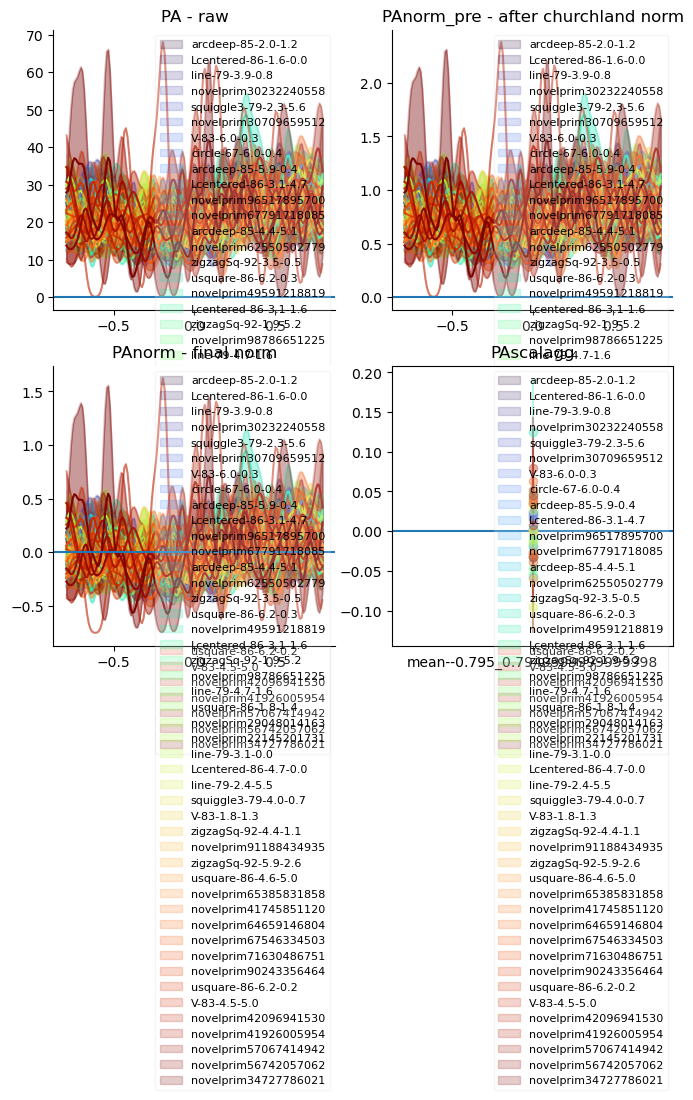

In [5]:
from neuralmonkey.classes.population_mult import dfallpa_preprocess_fr_normalization
# fr_normalization_method = "each_time_bin"
fr_normalization_method = "across_time_bins"
plot_savedir = "/tmp"
dfallpa_preprocess_fr_normalization(DFallpa, fr_normalization_method, plot_savedir)

### Factorize all relevant labels FIRST here.


In [6]:
if False: # Ingore this for now
    from neuralmonkey.analyses.decode_good import preprocess_factorize_class_labels_ints
    MAP_LABELS_TO_INT = preprocess_factorize_class_labels_ints(DFallpa)

### [Optional, for testing] Prune DFallPa to what you want to analyze

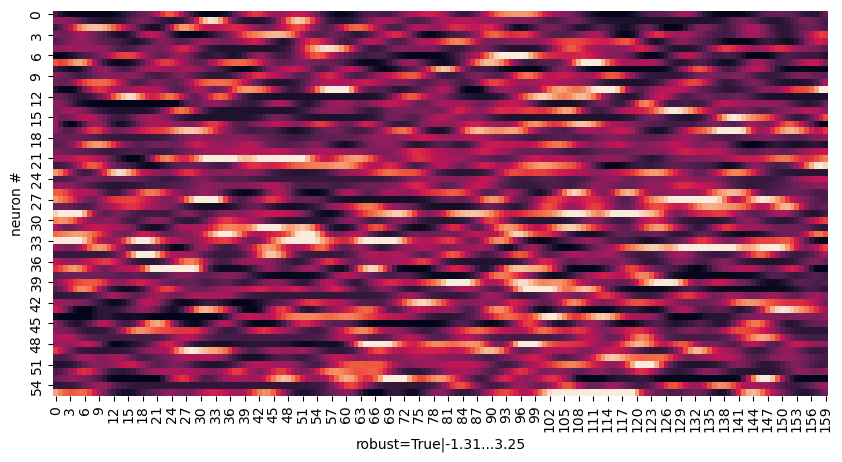

In [7]:
bregions = ["preSMA"]
events = ["03_samp"]

DFallpa = DFallpa[(DFallpa["bregion"].isin(bregions)) & (DFallpa["event"].isin(events))].reset_index(drop=True)
pa =DFallpa["pa"].values[0]
pa.plotNeurHeat(trial=100)



##### Extract a single PA for testing.


In [8]:

pa = DFallpa["pa"].values[0]



##### Train decoder (fiurst Extract data for pre-samp and post-samp)

In [9]:
from neuralmonkey.analyses.decode_moment import Decoder
var = "seqc_0_shape" # Decoded variable
twind_train = [0.1, 0.7]

Dc = Decoder(pa, var, twind_train)
Dc.train_decoder()


(731, 56)
731
Classes, in order:  ['Lcentered-86-1.6-0.0' 'Lcentered-86-3.1-1.6' 'Lcentered-86-3.1-4.7'
 'Lcentered-86-4.7-0.0' 'V-83-1.8-1.3' 'V-83-4.5-5.0' 'V-83-6.0-0.3'
 'arcdeep-85-2.0-1.2' 'arcdeep-85-4.4-5.1' 'arcdeep-85-5.9-0.4'
 'circle-67-6.0-0.4' 'line-79-2.4-5.5' 'line-79-3.1-0.0' 'line-79-3.9-0.8'
 'line-79-4.7-1.6' 'novelprim221452017317-91-5.3-1.4'
 'novelprim290480141634-125-4.1-0.1' 'novelprim302322405581-125-4.6-0.1'
 'novelprim307096595122-125-3.3-1.5' 'novelprim347277860216-130-4.9-0.9'
 'novelprim417458511209-102-4.5-2.3' 'novelprim419260059546-115-3.8-2.3'
 'novelprim420969415309-102-3.4-1.7' 'novelprim495912188195-130-4.6-2.2'
 'novelprim567420570629-90-3.4-0.9' 'novelprim570674149421-115-3.3-2.2'
 'novelprim625505027794-130-5.3-1.5' 'novelprim646591468043-75-5.3-0.7'
 'novelprim65385831858-75-5.3-0.1' 'novelprim675463345033-91-5.3-0.1'
 'novelprim677917180851-125-4.5-0.7' 'novelprim716304867517-130-5.3-0.9'
 'novelprim902433564644-125-3.8-1.4' 'novelprim91188434

In [10]:
Dc.MultiLabelBinarizer.classes_

array(['Lcentered-86-1.6-0.0', 'Lcentered-86-3.1-1.6',
       'Lcentered-86-3.1-4.7', 'Lcentered-86-4.7-0.0', 'V-83-1.8-1.3',
       'V-83-4.5-5.0', 'V-83-6.0-0.3', 'arcdeep-85-2.0-1.2',
       'arcdeep-85-4.4-5.1', 'arcdeep-85-5.9-0.4', 'circle-67-6.0-0.4',
       'line-79-2.4-5.5', 'line-79-3.1-0.0', 'line-79-3.9-0.8',
       'line-79-4.7-1.6', 'novelprim221452017317-91-5.3-1.4',
       'novelprim290480141634-125-4.1-0.1',
       'novelprim302322405581-125-4.6-0.1',
       'novelprim307096595122-125-3.3-1.5',
       'novelprim347277860216-130-4.9-0.9',
       'novelprim417458511209-102-4.5-2.3',
       'novelprim419260059546-115-3.8-2.3',
       'novelprim420969415309-102-3.4-1.7',
       'novelprim495912188195-130-4.6-2.2',
       'novelprim567420570629-90-3.4-0.9',
       'novelprim570674149421-115-3.3-2.2',
       'novelprim625505027794-130-5.3-1.5',
       'novelprim646591468043-75-5.3-0.7',
       'novelprim65385831858-75-5.3-0.1',
       'novelprim675463345033-91-5.3-0.1',
    

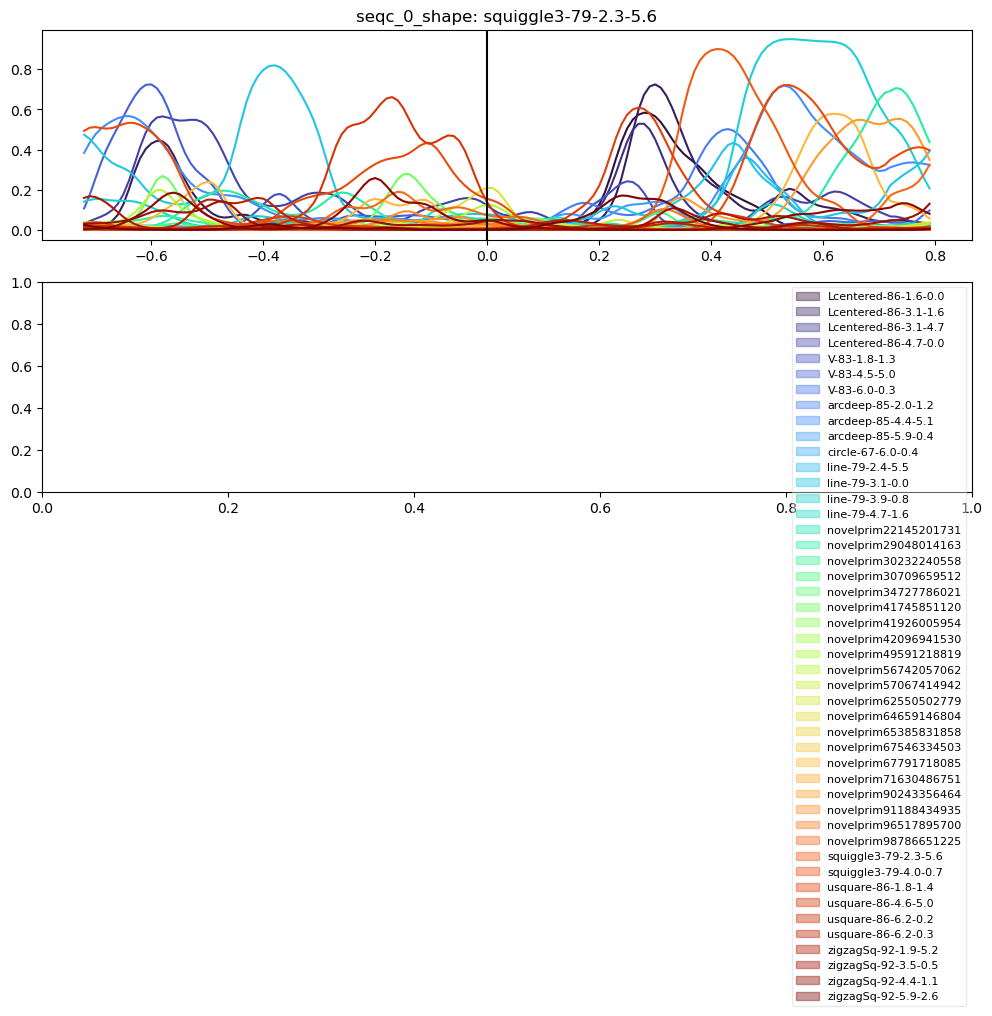

In [11]:
trial = 100
Dc.plot_single_trial(trial)

##### Get a single scalar score (by averaging the decode across time bins)


In [12]:
# Return array (ntrials, ndecodeclasses, ntwinds)

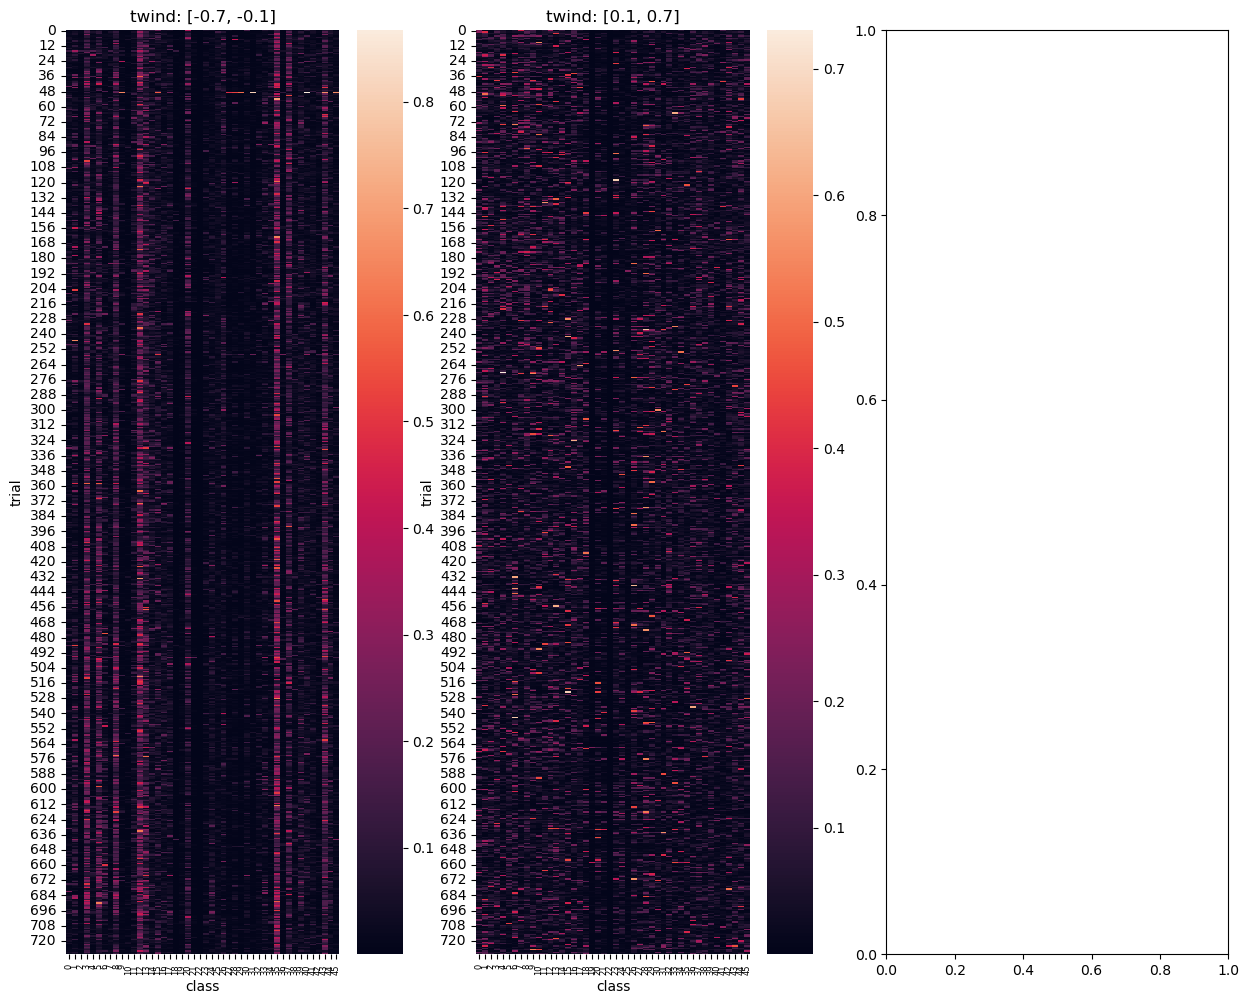

In [13]:
list_twind = [
    [-0.7, -0.1],
    [0.1, 0.7],
]

scores = Dc.scalar_score_twinds_trials(list_twind)

##### Average the decode over trials, to return a single row per trial class

In [14]:
# Returns array: (ntrial classes, n decode clasess, ntwinds)

0 ('Lcentered-86-1.6-0.0',)
0 ('Lcentered-86-3.1-1.6',)
0 ('Lcentered-86-3.1-4.7',)
0 ('Lcentered-86-4.7-0.0',)
0 ('V-83-1.8-1.3',)
0 ('V-83-4.5-5.0',)
0 ('V-83-6.0-0.3',)
0 ('arcdeep-85-2.0-1.2',)
0 ('arcdeep-85-4.4-5.1',)
0 ('arcdeep-85-5.9-0.4',)
0 ('circle-67-6.0-0.4',)
0 ('line-79-2.4-5.5',)
0 ('line-79-3.1-0.0',)
0 ('line-79-3.9-0.8',)
0 ('line-79-4.7-1.6',)
0 ('novelprim221452017317-91-5.3-1.4',)
0 ('novelprim290480141634-125-4.1-0.1',)
0 ('novelprim302322405581-125-4.6-0.1',)
0 ('novelprim307096595122-125-3.3-1.5',)
0 ('novelprim347277860216-130-4.9-0.9',)
0 ('novelprim417458511209-102-4.5-2.3',)
0 ('novelprim419260059546-115-3.8-2.3',)
0 ('novelprim420969415309-102-3.4-1.7',)
0 ('novelprim495912188195-130-4.6-2.2',)
0 ('novelprim567420570629-90-3.4-0.9',)
0 ('novelprim570674149421-115-3.3-2.2',)
0 ('novelprim625505027794-130-5.3-1.5',)
0 ('novelprim646591468043-75-5.3-0.7',)
0 ('novelprim65385831858-75-5.3-0.1',)
0 ('novelprim675463345033-91-5.3-0.1',)
0 ('novelprim67791718085

array([[[0.0266372 , 0.19693252],
        [0.05357735, 0.12150062],
        [0.01179721, 0.06835159],
        ...,
        [0.15421637, 0.0436123 ],
        [0.02610898, 0.03345859],
        [0.04895463, 0.05007348]],

       [[0.02439855, 0.06343672],
        [0.04366894, 0.32385683],
        [0.00720803, 0.09159361],
        ...,
        [0.15296629, 0.07561996],
        [0.04474831, 0.06388414],
        [0.02048996, 0.02859083]],

       [[0.02259546, 0.0562876 ],
        [0.06407251, 0.10035963],
        [0.00459392, 0.24012166],
        ...,
        [0.1511853 , 0.0411658 ],
        [0.04785509, 0.06242568],
        [0.01909035, 0.06447793]],

       ...,

       [[0.04978173, 0.02627472],
        [0.05941336, 0.09901953],
        [0.00601276, 0.02745927],
        ...,
        [0.15544148, 0.20706596],
        [0.05132106, 0.05417678],
        [0.01248412, 0.06296293]],

       [[0.02847277, 0.02499377],
        [0.0498844 , 0.10378115],
        [0.00779775, 0.05305892],
        .

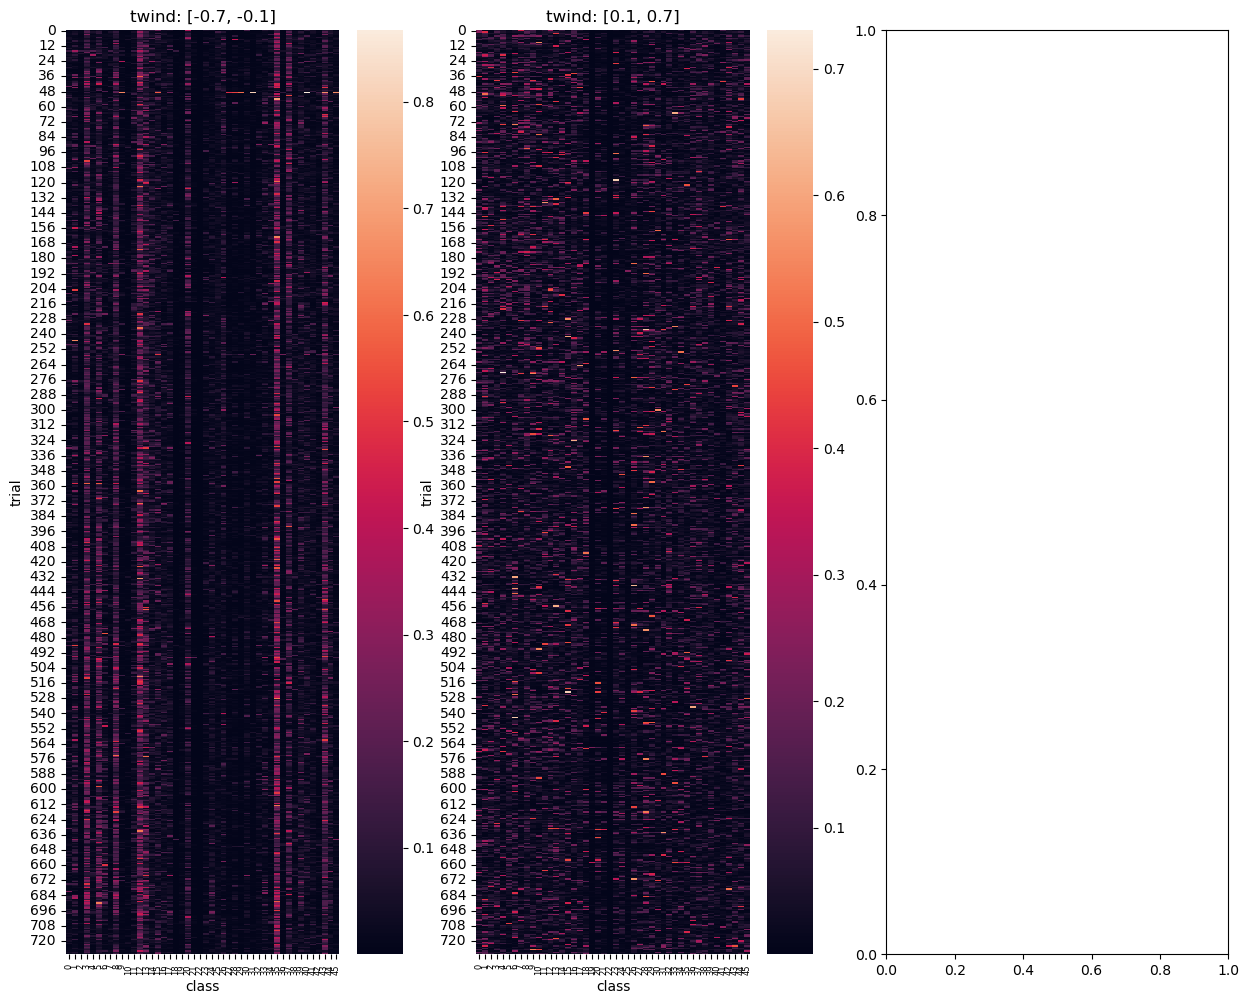

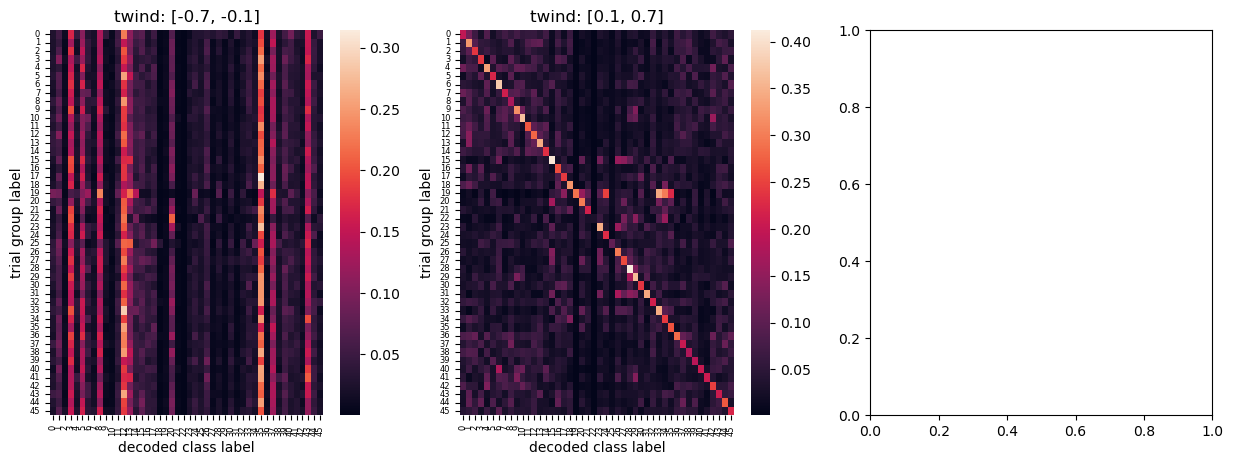

In [15]:
vars_trial = ["seqc_0_shape"]

Dc.scalar_score_twinds_trialgroupings(vars_trial, list_twind)

#### plot after sort labels


In [16]:
# NOTE: this is written for a very specific expeirmetn (Novel vs. orig prims)_.

In [17]:
def F(x):
    if "novelprim" in x:
        return f"2{x}"
    elif "presamp" in x:
        return f"3{x}"
    else:
        return f"1{x}"


In [18]:
labs_rows = [x[0] for x in grpdict.keys()]
labs_for_sorting = [F(x) for x in labs_rows]
inds = np.argsort(labs_for_sorting)
print(labs_for_sorting)
res_sorted = resthis[inds, :, :]
labs_rows_sorted = [labs_rows[i] for i in inds]

labs_cols = mlb.classes_
labs_for_sorting = [F(x) for x in labs_cols]
print(labs_for_sorting)
inds = np.argsort(labs_for_sorting)
res_sorted = res_sorted[:, inds, :]
labs_cols_sorted = [labs_cols[i] for i in inds]

from pythonlib.tools.snstools import heatmap_mat

ncols = 3
nrows = int(np.ceil(len(list_twind)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*7, nrows*5))

for ax, ind_twind in zip(axes.flatten(), range(len(list_twind))):
    if True:
        heatmap_mat(res_sorted[:, :, ind_twind], ax, False, zlims=(0, 0.3))    
        ax.set_xlabel("decoded class label")
        ax.set_ylabel("trial label")
        ax.set_title(f"twind: {list_twind[ind_twind]}")
    else:
        res_vec = np.mean(res_sorted[:, :, ind_twind], axis=0)
        xlab = [f"{i}-{x[:1]}" for i, x in enumerate(labs_cols_sorted)]
        ax.plot(xlab, res_vec, "ok")

        from pythonlib.tools.plottools import rotate_x_labels
        rotate_x_labels(ax)
        ax.set_xlabel("decoded class label")
        ax.set_ylabel("trial label")
        ax.set_title(f"twind: {list_twind[ind_twind]}")
        ax.set_ylim([0, 0.1])

        

NameError: name 'grpdict' is not defined

# Older methods

### Extract single trial results

In [ ]:

# PARAMS
var_decode = "seqc_0_shape"
bregion = "PMv"
twind = (-0.4, 0.6)

In [ ]:

a = DFRES["var_decode"]==var_decode
b = DFRES["bregion"]==bregion
c = DFRES["twind"]==twind
dfthis = DFRES[a & b & c]

times = dfthis["time"]
import numpy as np
labels_predicted = np.stack(dfthis["labels_predicted"]).T # (ntrials, ntimes)
labels_test = np.stack(dfthis["labels_test"]).T
conf_scores = np.transpose(np.stack(dfthis["conf_scores"]), [1,0,2]) # (ntrials, ntimes, nclasses)

# score each time bin as correct or incorrect
labels_correct = (labels_predicted == labels_test).astype(int)


In [ ]:
# For each trial, what was its label
assert np.all(np.diff(labels_test, axis=1))==0, "otherwise cant do next step."
labels_each_trial = labels_test[:,0]
labels_orig = PA_test.Xlabels["trials"][var_decode].tolist()
assert len(labels_orig)==len(labels_each_trial)

map_labint_to_trials = {}
map_labint_to_laborig = {}
labels_unique = np.unique(labels_each_trial)
for lab in labels_unique:
    inds_this_label = np.argwhere(labels_each_trial == lab).squeeze() # the indices which ahve this label as the CORRECT
    map_labint_to_trials[lab] = inds_this_label

    # Map it back to original label
    lab_orig = PA_test.Xlabels["trials"][var_decode][inds_this_label].unique()
    assert len(lab_orig)==1
    map_labint_to_laborig[lab] = lab_orig[0]

map_trial_to_labint = {i:labint for i, labint in enumerate(labels_each_trial)}
print(map_labint_to_laborig)    
map_laborig_to_labint = {}
for labint, laborig in map_labint_to_laborig.items():
    assert laborig not in map_laborig_to_labint
    map_laborig_to_labint[laborig] = labint

import matplotlib.pyplot as plt
from pythonlib.tools.plottools import makeColors
pcols = makeColors(len(map_labint_to_laborig))
map_trial_to_seq = {}
map_trial_to_seq_ints = {}
for i, seq in enumerate(PA_test.Xlabels["trials"].loc[:, ["seqc_0_shape", "seqc_1_shape"]].values.tolist()):
    map_trial_to_seq[i] = (tuple(seq))
    map_trial_to_seq_ints[i] = [map_laborig_to_labint[s] if s in map_laborig_to_labint else s for s in seq]


In [ ]:
# Pick n random trials
import random
n=  9
trials_all = list(range(len(map_trial_to_labint)))
trials = random.sample(trials_all, n)
ncols = 3
nrows = int(np.ceil(len(trials)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), sharex=True, sharey=True)

for tr, ax in zip(trials, axes.flatten()):
    
    # ax = axes.flatten()[0]
    lab_pred = labels_predicted[tr,:]
    # lab_corr = labels_correct[trial,:]
    # lab_test = labels_test[trial,:]
    # ax.plot(times, lab_pred, "-ok"),
    # ax.plot(times, lab_test, "-r")
    
    # for each class, plot its time series
    for labint in map_labint_to_laborig:
        cs_this_lab = conf_scores[tr, :, labint].squeeze()
        
        ax.plot(times, cs_this_lab, label=labint, color=pcols[labint])
        # ax.plot(times[lab_pred==labint], cs_this_lab[lab_pred==labint], "-", color=pcols[labint], linewidth=4)
        ax.plot(times[lab_pred==labint], cs_this_lab[lab_pred==labint], "s", color=pcols[labint])
    
    ax.axvline(0, color="k", alpha=0.5)
    ax.set_title(f"{var_decode}={map_trial_to_labint[tr]}", color=pcols[map_trial_to_labint[tr]])
    ax.set_xlabel(f"seq: {map_trial_to_seq_ints[tr]}")
    ax.legend()
        

In [ ]:
# For each class label, collect all trials for which that is the correct label, and overlap

labels_unique = np.unique(labels_each_trial)
ncols = 3
nrows = int(np.ceil(len(labels_unique)/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

for lab, ax in zip(labels_unique, axes.flatten()):
    inds_this_label = np.argwhere(labels_each_trial == lab).squeeze() # the indices which ahve this label as the CORRECT 
    ax.plot(times, labels_predicted[inds_this_label, :].T, "-ok", alpha=0.05)
    ax.set_title(lab)
    
    

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

ax = axes.flatten()[0]
ax.plot(times, labels_correct.T, "xk", alpha=0.003);

In [ ]:
##### Plot the results, comparing score across methods!!
%matplotlib inline
import seaborn as sns
fig = sns.relplot(data=DFRES, x="time", y="score", hue="bregion", col="var_decode",  kind="line")


In [ ]:
##### Plot the results, comparing score across methods!!
%matplotlib inline
import seaborn as sns
fig = sns.relplot(data=DFRES, x="time", y="score", hue="bregion", col="var_decode",  kind="line")


In [ ]:
from neuralmonkey.analyses.decode_good import decodewrapouterloop_categorical_cross_time